In [10]:
#import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
#import folium
import csv
import io
import urllib.request
from datetime import datetime, timedelta
import numpy as np

In [11]:
# TODOS
# change attempt to 0-1
# check for missing values in estimated_values (9999?, 0)
# check for outliers
# Normalize or bin "estimated_values"

# Put bike types with too little obsevations together to "other"
#  What to do with "Fahrrad" bike type
# Encode categorical values

# Data Loading

In [12]:
url = "https://www.internetwache-polizei-berlin.de/vdb/Fahrraddiebstahl.csv"

download = requests.get(url)
decoded_content = download.content.decode('ISO-8859-1')
file = decoded_content.splitlines()

# cr = csv.reader(file, delimiter=',')
cr = csv.DictReader(file, delimiter=',')
my_list = list(cr)
df = pd.DataFrame(my_list)

In [13]:
df.head()

,ANGELEGT_AM,TATZEIT_ANFANG_DATUM,TATZEIT_ANFANG_STUNDE,TATZEIT_ENDE_DATUM,TATZEIT_ENDE_STUNDE,LOR,SCHADENSHOEHE,VERSUCH,ART_DES_FAHRRADS,DELIKT,ERFASSUNGSGRUND
0,06.03.2022,06.03.2022,07,06.03.2022,09,02200211,900,Nein,Fahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
1,06.03.2022,06.03.2022,13,06.03.2022,22,07300619,799,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
2,06.03.2022,05.03.2022,14,06.03.2022,14,07200413,789,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
3,06.03.2022,05.03.2022,11,06.03.2022,18,07200413,650,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
4,06.03.2022,05.03.2022,16,06.03.2022,15,03701660,2035,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern


# Data Cleaning of the Bike Theft dataset

Cleaning steps: 
- Translation
- Duplicates
- Missing values
- outliers
- scaling
- balancing

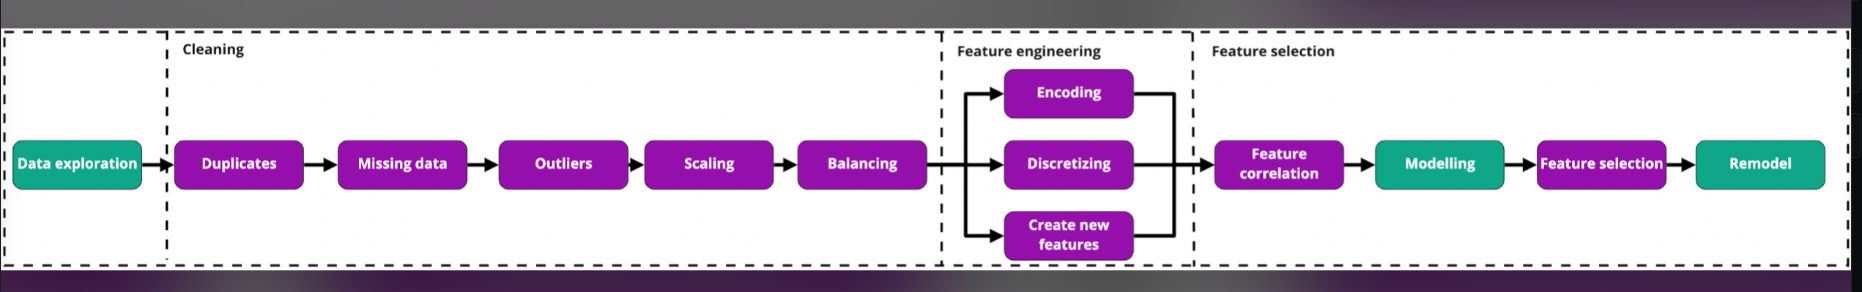

## Translation

### Translate column names

In [14]:
df.columns

Index(['ANGELEGT_AM', 'TATZEIT_ANFANG_DATUM', 'TATZEIT_ANFANG_STUNDE',
       'TATZEIT_ENDE_DATUM', 'TATZEIT_ENDE_STUNDE', 'LOR', 'SCHADENSHOEHE',
       'VERSUCH', 'ART_DES_FAHRRADS', 'DELIKT', 'ERFASSUNGSGRUND'],
      dtype='object')

In [15]:
eng_col_names = {
    "ANGELEGT_AM": "date_reported",
    "TATZEIT_ANFANG_DATUM": "date_theft_start",
    "TATZEIT_ANFANG_STUNDE": "hour_theft_start",
    "TATZEIT_ENDE_DATUM": "date_theft_end",
    "TATZEIT_ENDE_STUNDE": "hour_theft_end",
    "LOR": "LOR",
    "SCHADENSHOEHE": "estimated_value",
    "VERSUCH": "attempt",
    "ART_DES_FAHRRADS": "type_bike", 
    "DELIKT": "theft_type",
    "ERFASSUNGSGRUND": "theft_type_detail"    
}

In [16]:
df.rename(columns= eng_col_names, inplace=True)

In [17]:
df.columns

Index(['date_reported', 'date_theft_start', 'hour_theft_start',
       'date_theft_end', 'hour_theft_end', 'LOR', 'estimated_value', 'attempt',
       'type_bike', 'theft_type', 'theft_type_detail'],
      dtype='object')

### Translate categories

In [18]:
# pd.DataFrame(df[["type_bike", "attempt", "theft_type", "theft_type_detail"]].value_counts())

#### Type_bike

In [19]:
df["type_bike"].value_counts().keys()

Index(['Herrenfahrrad', 'Damenfahrrad', 'Fahrrad', 'Mountainbike',
       'Kinderfahrrad', 'diverse Fahrräder', 'Rennrad', 'Lastenfahrrad'],
      dtype='object')

In [20]:
# define function for renaming the categories
def rename_type_bike(x): 
    if x == "Herrenfahrrad": 
        return "man's bike"
    if x == "Damenfahrrad":
        return "woman's bike"
    if x == "Fahrrad":
        return "bike"
    if x == "Kinderfahrrad":
        return "child's bike"
    else: 
        return "other bike"

In [21]:
df["type_bike"] = df["type_bike"].apply(rename_type_bike)

In [22]:
df["type_bike"].value_counts()

man's bike      10244
woman's bike     6547
bike             2698
other bike       1814
child's bike      850
Name: type_bike, dtype: int64

#### attempt

In [23]:
df["attempt"].value_counts()

Nein         22058
Ja              85
Unbekannt       10
Name: attempt, dtype: int64

In [24]:
attempt_dict = {
    "Ja": "Yes", 
    "Nein": "No", 
    "Unbekannt": "Unknown"
}

In [25]:
# change "yes"/"no"/"unknown" to 0/1/"unknown"
df["attempt"] = df["attempt"].map(attempt_dict)

In [26]:
df["attempt"].value_counts()

No         22058
Yes           85
Unknown       10
Name: attempt, dtype: int64

#### Theft type and theft type detail

In [27]:
# Leaving in German for now

## Change dtypes

In [28]:
# convert the date columns
df["date_reported"] = pd.to_datetime(df["date_reported"], format='%d.%m.%Y')
df["date_theft_start"] = pd.to_datetime(df["date_theft_start"], format='%d.%m.%Y')
df["date_theft_end"] = pd.to_datetime(df["date_theft_end"], format='%d.%m.%Y')

# convert the time columns 
df["hour_theft_start"] = df["hour_theft_start"].astype(int)
df["hour_theft_end"] = df["hour_theft_end"].astype(int)


df.dtypes

date_reported        datetime64[ns]
date_theft_start     datetime64[ns]
hour_theft_start              int64
date_theft_end       datetime64[ns]
hour_theft_end                int64
LOR                          object
estimated_value              object
attempt                      object
type_bike                    object
theft_type                   object
theft_type_detail            object
dtype: object

In [29]:
df["estimated_value"] = df["estimated_value"].astype(float)

In [30]:
df.dtypes

date_reported        datetime64[ns]
date_theft_start     datetime64[ns]
hour_theft_start              int64
date_theft_end       datetime64[ns]
hour_theft_end                int64
LOR                          object
estimated_value             float64
attempt                      object
type_bike                    object
theft_type                   object
theft_type_detail            object
dtype: object

## Duplicates

In [31]:
df.duplicated().sum()

36

In [32]:
df = df.drop_duplicates()

## Missing data

In [33]:
df.isna().sum()

date_reported        0
date_theft_start     0
hour_theft_start     0
date_theft_end       0
hour_theft_end       0
LOR                  0
estimated_value      0
attempt              0
type_bike            0
theft_type           0
theft_type_detail    0
dtype: int64

In [34]:
df.dtypes

date_reported        datetime64[ns]
date_theft_start     datetime64[ns]
hour_theft_start              int64
date_theft_end       datetime64[ns]
hour_theft_end                int64
LOR                          object
estimated_value             float64
attempt                      object
type_bike                    object
theft_type                   object
theft_type_detail            object
dtype: object

In [35]:
# check min and max for date and time columns
for col in list(df.columns[:5]):
    #print(col)
    print(f"min of {col}:  {df[col].min()}")
    print(f"max of {col}:  {df[col].max()}")

min of date_reported:  2021-01-01 00:00:00
max of date_reported:  2022-03-06 00:00:00
min of date_theft_start:  2021-01-01 00:00:00
max of date_theft_start:  2022-03-06 00:00:00
min of hour_theft_start:  0
max of hour_theft_start:  23
min of date_theft_end:  2021-01-01 00:00:00
max of date_theft_end:  2022-03-06 00:00:00
min of hour_theft_end:  0
max of hour_theft_end:  23


In [36]:
# check distribution of numerical variables 
df.describe()

,hour_theft_start,hour_theft_end,estimated_value
count,22117.000000,22117.000000,22117.000000
mean,14.509970,13.335534,905.861554
std,5.310801,5.245721,867.268300
min,0.000000,0.000000,0.000000
25%,10.000000,9.000000,400.000000
50%,16.000000,14.000000,650.000000
75%,19.000000,17.000000,1050.000000
max,23.000000,23.000000,9999.000000


### Estimated Value

Conclusion:  
- We have some bikes with "9999" as estimated value. These seem to be reasonable observations, that we'll keep
- We also have some bikes with "0" estimated value. These include both attempts and actually stolen bikes. 

--> Since we won't use estimated value for the first model, we will won't impute the "0" estimated value observations

In [37]:
df["estimated_value"].mode()

0    500.0
Name: estimated_value, dtype: float64

In [38]:
df["estimated_value"].sort_values(ascending= False).head(20)

1437     9999.0
4919     9999.0
2888     9559.0
14161    9500.0
3585     9420.0
10357    9000.0
9337     8450.0
10791    8449.0
21050    8400.0
20223    8027.0
18768    8000.0
7658     8000.0
20851    7999.0
2999     7990.0
9269     7899.0
6291     7871.0
6122     7798.0
5073     7700.0
10142    7500.0
21334    7500.0
Name: estimated_value, dtype: float64

In [39]:
df.sort_values(by = "estimated_value", ascending= False).head()

,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail
1437,2022-02-03,2022-02-03,16,2022-02-03,16,11300722,9999.0,No,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
4919,2021-11-16,2021-11-16,10,2021-11-16,11,11300723,9999.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
2888,2021-12-29,2021-12-26,19,2021-12-29,15,09501737,9559.0,No,man's bike,Keller- und Bodeneinbruch,Sonstiger schwerer Diebstahl in/aus Keller/Bod...
14161,2021-07-04,2021-07-04,16,2021-07-04,17,02400623,9500.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
3585,2021-12-12,2021-12-11,19,2021-12-12,18,03601140,9420.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern


In [40]:
# Estimated value: values of "9999" seem reasonable. Could be the case that the one can only enter 4 digits

In [41]:
# check "0" values for estimated value
df.sort_values(by = "estimated_value", ascending= True).head(20)

,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail
21035,2021-02-10,2021-02-09,22,2021-02-09,22,03701555,0.0,Yes,child's bike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern
6766,2021-10-20,2021-10-19,7,2021-10-19,8,01100103,0.0,No,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
17881,2021-04-29,2021-04-29,16,2021-04-29,16,03601244,0.0,Yes,man's bike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern
4226,2021-11-28,2021-11-28,14,2021-11-28,14,09200614,0.0,Yes,other bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
13571,2021-07-14,2021-07-14,8,2021-07-14,17,04300620,0.0,Yes,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
10894,2021-08-24,2021-08-24,11,2021-08-24,11,03400723,0.0,Yes,bike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern
9020,2021-09-19,2021-09-19,3,2021-09-19,3,10200423,0.0,Yes,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
4783,2021-11-19,2021-11-19,23,2021-11-19,23,06100208,0.0,Yes,woman's bike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern
1700,2022-01-27,2022-01-27,7,2022-01-27,15,11400929,0.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
14525,2021-06-27,2021-06-26,21,2021-06-26,21,01100103,0.0,Yes,man's bike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern


In [42]:
df[df["estimated_value"]==0].count()

date_reported        138
date_theft_start     138
hour_theft_start     138
date_theft_end       138
hour_theft_end       138
LOR                  138
estimated_value      138
attempt              138
type_bike            138
theft_type           138
theft_type_detail    138
dtype: int64

## Outliers

## Scaling


There is only one numerical variable (estimated value) that we could scale. As we don't use them right now, we can skip the scaling for now. 

# Feature Engineering

## Concat date and time

In [43]:
# add minute and seconds to hour column 
df["hour_theft_start"] = df["hour_theft_start"].astype(str) + ":00:00"

In [44]:
df["hour_theft_end"]  = df["hour_theft_end"].astype(str) + ":00:00"

In [45]:
df["datetime_theft_start"] = df["date_theft_start"].astype(str) + " " + df["hour_theft_start"].astype(str)
df["datetime_theft_end"] = df["date_theft_end"].astype(str) + " " + df["hour_theft_end"].astype(str)

In [46]:
df["datetime_theft_start"] = pd.to_datetime(df["datetime_theft_start"]) 
df["datetime_theft_end"] = pd.to_datetime(df["datetime_theft_end"]) 

In [47]:
df.head()

,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail,datetime_theft_start,datetime_theft_end
0,2022-03-06,2022-03-06,7:00:00,2022-03-06,9:00:00,02200211,900.0,No,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-03-06 07:00:00,2022-03-06 09:00:00
1,2022-03-06,2022-03-06,13:00:00,2022-03-06,22:00:00,07300619,799.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-03-06 13:00:00,2022-03-06 22:00:00
2,2022-03-06,2022-03-05,14:00:00,2022-03-06,14:00:00,07200413,789.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-03-05 14:00:00,2022-03-06 14:00:00
3,2022-03-06,2022-03-05,11:00:00,2022-03-06,18:00:00,07200413,650.0,No,woman's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-03-05 11:00:00,2022-03-06 18:00:00
4,2022-03-06,2022-03-05,16:00:00,2022-03-06,15:00:00,03701660,2035.0,No,woman's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-03-05 16:00:00,2022-03-06 15:00:00


## Calculate time delta

In [48]:
df["Timedelta_theft_end_start"] = (df["datetime_theft_end"] - df["datetime_theft_start"]).astype('timedelta64[h]')

In [49]:
df.head()

,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail,datetime_theft_start,datetime_theft_end,Timedelta_theft_end_start
0,2022-03-06,2022-03-06,7:00:00,2022-03-06,9:00:00,02200211,900.0,No,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-03-06 07:00:00,2022-03-06 09:00:00,2.0
1,2022-03-06,2022-03-06,13:00:00,2022-03-06,22:00:00,07300619,799.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-03-06 13:00:00,2022-03-06 22:00:00,9.0
2,2022-03-06,2022-03-05,14:00:00,2022-03-06,14:00:00,07200413,789.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-03-05 14:00:00,2022-03-06 14:00:00,24.0
3,2022-03-06,2022-03-05,11:00:00,2022-03-06,18:00:00,07200413,650.0,No,woman's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-03-05 11:00:00,2022-03-06 18:00:00,31.0
4,2022-03-06,2022-03-05,16:00:00,2022-03-06,15:00:00,03701660,2035.0,No,woman's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-03-05 16:00:00,2022-03-06 15:00:00,23.0


<AxesSubplot:xlabel='Timedelta_theft_end_start', ylabel='estimated_value'>

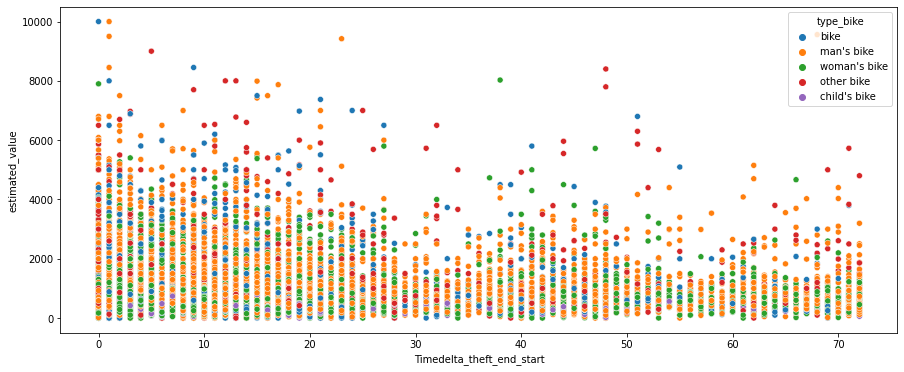

In [50]:
plt.figure(figsize = (15, 6))
sns.scatterplot(data = df, x = "Timedelta_theft_end_start", y = "estimated_value", hue ="type_bike")

<AxesSubplot:xlabel='Timedelta_theft_end_start', ylabel='Count'>

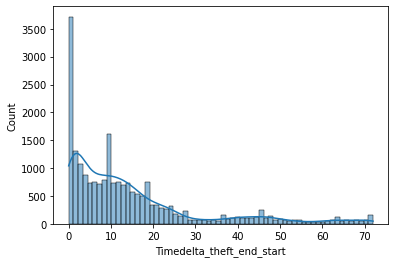

In [51]:
sns.histplot(x = df["Timedelta_theft_end_start"], kde = True)

In [52]:
df[df["Timedelta_theft_end_start"] == 0].count()

date_reported                2198
date_theft_start             2198
hour_theft_start             2198
date_theft_end               2198
hour_theft_end               2198
LOR                          2198
estimated_value              2198
attempt                      2198
type_bike                    2198
theft_type                   2198
theft_type_detail            2198
datetime_theft_start         2198
datetime_theft_end           2198
Timedelta_theft_end_start    2198
dtype: int64

In [53]:
# Conclusion: Timedelta between theft start and end doesn't give any meaningfull insights.
#  Caclulating whether the bike was stolen during the day or at night is not possible, as we have many timedeltas
#  > 24 hours. 

## Calculate mean between theft start and end

In [54]:
# We first have to convert the Timedelta column to datetime.timedelta and specify that it is only hours. 
# Then add the Timedelta divided by 2 to the datetime_theft_start

df["datetime_theft_mean"] = df["datetime_theft_start"] + (df["Timedelta_theft_end_start"].apply(lambda x: timedelta(hours = x)) /2 )

## Extracting higher levels from LOR

In [55]:
# BZR (first six numbers)
df["BZR"] = df["LOR"].str[:6]

In [56]:
# PGR (first four numbers)
df["PGR"] = df["LOR"].str[:4]

In [62]:
# Bezirk (first four numbers)
df["Bezirk"] = df["LOR"].str[:2]

In [57]:
df

,date_reported,date_theft_start,hour_theft_start,date_theft_end,hour_theft_end,LOR,estimated_value,attempt,type_bike,theft_type,theft_type_detail,datetime_theft_start,datetime_theft_end,Timedelta_theft_end_start,datetime_theft_mean,BZR,PGR
0,2022-03-06,2022-03-06,7:00:00,2022-03-06,9:00:00,02200211,900.0,No,bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-03-06 07:00:00,2022-03-06 09:00:00,2.0,2022-03-06 08:00:00,022002,0220
1,2022-03-06,2022-03-06,13:00:00,2022-03-06,22:00:00,07300619,799.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-03-06 13:00:00,2022-03-06 22:00:00,9.0,2022-03-06 17:30:00,073006,0730
2,2022-03-06,2022-03-05,14:00:00,2022-03-06,14:00:00,07200413,789.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-03-05 14:00:00,2022-03-06 14:00:00,24.0,2022-03-06 02:00:00,072004,0720
3,2022-03-06,2022-03-05,11:00:00,2022-03-06,18:00:00,07200413,650.0,No,woman's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-03-05 11:00:00,2022-03-06 18:00:00,31.0,2022-03-06 02:30:00,072004,0720
4,2022-03-06,2022-03-05,16:00:00,2022-03-06,15:00:00,03701660,2035.0,No,woman's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2022-03-05 16:00:00,2022-03-06 15:00:00,23.0,2022-03-06 03:30:00,037016,0370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22148,2021-01-02,2021-01-01,1:00:00,2021-01-02,10:00:00,01200517,200.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2021-01-01 01:00:00,2021-01-02 10:00:00,33.0,2021-01-01 17:30:00,012005,0120
22149,2021-01-01,2021-01-01,20:00:00,2021-01-01,20:00:00,02100104,2800.0,No,man's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2021-01-01 20:00:00,2021-01-01 20:00:00,0.0,2021-01-01 20:00:00,021001,0210
22150,2021-01-01,2021-01-01,17:00:00,2021-01-01,18:00:00,08401241,888.0,No,bike,Fahrraddiebstahl,Einfacher Diebstahl von Fahrrädern,2021-01-01 17:00:00,2021-01-01 18:00:00,1.0,2021-01-01 17:30:00,084012,0840
22151,2021-01-01,2021-01-01,9:00:00,2021-01-01,11:00:00,04200206,290.0,No,woman's bike,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2021-01-01 09:00:00,2021-01-01 11:00:00,2.0,2021-01-01 10:00:00,042002,0420


# Save cleaned dataset

In [63]:
df.to_csv("../raw_data/bike_theft_cleaned.csv")